In [1]:
import networkit as nit
import numpy as np
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
import copy
import random

In [2]:
def louvain(graph, passes = 1):
    '''
    implements louvain method of clustering
    still need to implement passes (for now change number of iterations in change_modularity to increase modularity)
    and total_modularity where algo stops when modularity of whole graph doesn't change
    '''
    graph_lst = [graph]
    for j in range(0,passes):
        mapping = modularity_optimization(graph_lst[-1]) #first phase - modularity optimization
        new_graph = copy.deepcopy(graph_lst[-1])
        new_graph, nodes_lst = community_aggression(mapping,new_graph) #second phase - community aggression
        visualize(graph, [i for i in graph.iterNodes()],[i for i in nodes_lst.values()])
        graph_lst.append(new_graph) #appends new graph to run second pass
    return 

In [3]:
def community_aggression(mapping, graph):
    '''
    groups all the nodes with corresponding communities by making a new node for each community
    '''
    community = set(frozenset(i) for i in mapping.values()) 
    new = dict() # a mapping to maintain which node belongs to which new node
    for i in community:
        newNode = graph.addNode()
        new[newNode]= i 
        for node in i:
            for neighbor in graph.iterNeighbors(node): #loops through each neighbor of node to link edges to new community node
                if neighbor in i:
                    graph.addEdge(newNode,newNode,graph.weight(node,neighbor)) #if node has an edge to a node which is in same community then it makes a self-loop
                else:
                    graph.addEdge(newNode,neighbor,graph.weight(node,neighbor))
            graph.removeNode(node)
    return graph, new 

In [4]:
def modularity_optimization(graph):
    '''
    assigns each node to a community which maximizes the modularity
    '''
    nodes = [i for i in graph.iterNodes()] 
    mapping = {i:{i} for i in graph.iterNodes()} # initially each node is assigned to its own community
    for _ in range(0,8): # still need to implement passes in louvain so to see better modularity u can increase number of iterations
        for nodeid in nodes:
            lst = [i for i in graph.iterNeighbors(nodeid)]
            nodeid_community = copy.deepcopy(mapping[nodeid]) 
            if lst:
                mergeid = max(lst, key=lambda x: change_modularity(nodeid,mapping[x],graph)) 
                if mergeid in nodeid_community: #if mergeid is already in community then no need to do anything
                    continue
                k = copy.deepcopy(mapping[mergeid])
                for i in k: #appends nodeid to the community
                    mapping[i].add(nodeid)
                for i in nodeid_community: #removes nodeid from initially assigned community
                    mapping[i].remove(nodeid)
                mapping[nodeid] = k.union({nodeid})
    return mapping

In [5]:
def change_modularity(node, community, graph):
    ''' implements change in modularity equation and returns a tuple where first arg is change in modularity and second is either 1 or 0 depending if node is in the community
    '''
    kiin = sum(graph.weight(node, i) for i in community)
    ki = graph.weightedDegree(node)
    sum_tot = sum(graph.weightedDegree(i) for i in community)
    m = graph.totalEdgeWeight()/2
    return (kiin/m)-((sum_tot*ki)/(2*m*m)), int(node in community)

In [71]:
def visualize(graph, nodelst = [], lst = []):
    ''' visiualizes the graph
    '''
    plt.clf() #clear the sreen
    matrix = nit.algebraic.adjacencyMatrix(graph, matrixType='sparse') #make adjancency matrix of graph to convert it to a graph object of networkx
    G2 = nx.from_scipy_sparse_matrix(matrix)# converts the graph
    if not lst: #this is for just viewing graph
        nx.draw(G2,with_labels=True)
    else: #this is for viewing graph with colors to see clusters
        colors = [random.uniform(0,0.1) for _ in range(0,len(lst))]
        color_lst = []
        for i in nodelst:
            for index, j in enumerate(lst):
                if i in j:
                    color_lst.append(colors[index])
        nx.draw(G2,nodelist = nodelst ,with_labels=True, node_color = color_lst)
    plt.axis('equal')

In [72]:
graph = nit.generators.ClusteredRandomGraphGenerator(50,5,0.1,0.1).generate()
#graph = nit.generators.ErdosRenyiGenerator(10, 0.1, directed = False, selfLoops = False).generate()

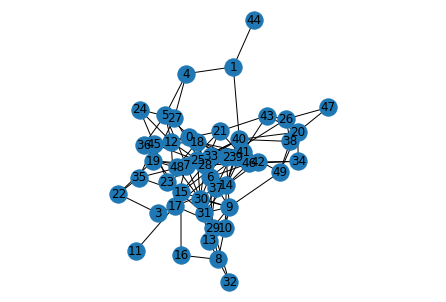

In [73]:
visualize(graph)

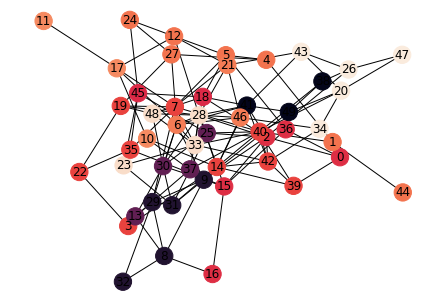

In [74]:
louvain(graph)